# Initialisation and Dependencies

In [1]:
import sys
lib_path = '/home/jovyan/libs'
sys.path.insert(0, lib_path)

In [18]:
import gc, math, traceback, datetime

import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from datasets import load_from_disk

import whisper
from whisper.tokenizer import get_tokenizer

from tqdm import tqdm

from utils import audio, training
from utils.attacks import PrepareMethod, PrepareFront

from typing import Optional

# GPU RAM Tracking

In [3]:
def print_cuda_usage(msg: str = ""):
    if torch.cuda.is_available():
        print(f"{msg}{torch.cuda.memory_allocated(0)/(1024 ** 3)} GB")

def get_cuda_usage():
    return torch.cuda.memory_allocated(0)/(1024 ** 3)

In [4]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [5]:
device

'cuda'

# Load Model

In [6]:
try:
    del model
    print("Model deleted!")
except:
    pass

In [7]:
MODEL_NAME = "tiny.en"

model = whisper.load_model(MODEL_NAME).to(device)
model.eval();

/home/jovyan/libs/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)


In [8]:
tokenizer = get_tokenizer(model.is_multilingual, num_languages=model.num_languages, language="en", task="transcribe")
sot_ids = torch.tensor(tokenizer.sot_sequence_including_notimestamps, requires_grad=False)

# Load Data

In [9]:
tedlium_path = "../tedlium"
train_path, validation_path, test_path = f"{tedlium_path}/train_idx.hf", f"{tedlium_path}/validation_idx.hf", f"{tedlium_path}/test.hf"

In [10]:
TRAIN_SELECT = 500
VALID_SELECT = 150
TEST_SELECT = 250

SEED = 1

tedlium_train = load_from_disk(train_path).with_format("torch").shuffle(seed=SEED).select(range(TRAIN_SELECT))
tedlium_validation = load_from_disk(validation_path).with_format("torch").shuffle(seed=SEED).select(range(VALID_SELECT))
tedlium_test = load_from_disk(test_path).with_format("torch").shuffle(seed=SEED).select(range(TEST_SELECT))

Loading dataset from disk:   0%|          | 0/109 [00:00<?, ?it/s]

In [11]:
def collate(ls):
    pad_to = max(list(map(lambda x: x["audio"].shape[0], ls)))
    return torch.cat(list(map(lambda x: F.pad(x["audio"], (0, pad_to - x["audio"].shape[0])).unsqueeze(0).to(torch.bfloat16), ls)), dim=0)

def collate_idx(ls):
    return ls[0]["audio"].unsqueeze(0), ls[0]["idx"].item()

TRAIN_BATCH_SIZE = 1 # highly recommended to be 1
VALID_BATCH_SIZE = 1

train_dataset = DataLoader(tedlium_train, batch_size=TRAIN_BATCH_SIZE, collate_fn=collate_idx)
validation_dataset = DataLoader(tedlium_validation, batch_size=VALID_BATCH_SIZE, collate_fn=collate_idx)
test_dataset = DataLoader(tedlium_test)

# Training Loop

In [27]:
def training_autograd_more(model: whisper.model.Whisper,
                      train_data: torch.utils.data.DataLoader, valid_data: torch.utils.data.DataLoader,
                      prepare_method: PrepareMethod,
                      writer: Optional[SummaryWriter] = None,
                      train_success: Optional[dict] = None, valid_success: Optional[dict] = None,
                      lr: float = 1e-3,
                      iter_limit: Optional[int] = None, mins_limit: Optional[int] = None, patience: Optional[int] = None, clamp_epsilon: Optional[float] = None
                          ) -> torch.Tensor:
    
    # initialise stuff
    torch.autograd.set_detect_anomaly(False)
    loss = torch.tensor(np.inf, requires_grad=True)
    num_training_batches = len(train_data)
    num_valid_batches = len(valid_data)

    time_limit = mins_limit * 60 if mins_limit else None

    snippet = torch.rand(prepare_method.snippet_size, requires_grad=True, device=device) # adversarial snippet
    
    snippets = [snippet]
    buffer = None

    if clamp_epsilon:
        with torch.no_grad():
            snippet = snippet * clamp_epsilon
    snippet.requires_grad = True

    optim = torch.optim.AdamW([snippet], lr=lr, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.5)

    attack_stack, attacked_data, mel, logits, pbar, avg_valid_loss = None, None, None, None, None, None
    lowest_valid_loss = np.inf
    curr_patience = patience
    best_snippet = snippet.detach().clone()

    # display attack method and snippet for sanity check
    print(f"Prepare method: {prepare_method.name}")
    print(f"Snippet initialised to [{torch.min(snippet)}, {torch.max(snippet)}] of size {prepare_method.snippet_size}")
    print(f"Clamp: {clamp_epsilon}\nTime Limit (Mins): {mins_limit}\nEpochs Limit: {iter_limit}")
    print(f"Tracking training success: {train_success is not None}\nTracking valid success: {valid_success is not None}")

    # log attack snippet
    if writer:
        writer.add_image("Attack Snippet", audio.mel_image(snippet.detach().to("cpu")), 0, dataformats="HWC")
        writer.flush()

    # progress bar
    pbar = tqdm(range(1), desc="Training", ncols=0)
    itera = 0

    # track gpu usage
    base_cuda_usage = get_cuda_usage()

    try:
        while True:
            buffer = torch.zeros((len(train_data), 1))
            itera += 1
            if iter_limit:
                iter_limit -= 1
                if iter_limit <= 0:
                    pbar.set_postfix_str("Epoch limit reached! Terminating...")
                    break
            if time_limit and pbar.format_dict["elapsed"] >= time_limit:
                pbar.set_postfix_str("Time limit reached! Terminating...")
                break
            if patience and avg_valid_loss:
                if curr_patience <= 0:
                    pbar.set_postfix_str("Patience expired! Terminating...")
                    break
            if clamp_epsilon and audio.violates_clamp(snippet, clamp_epsilon):
                raise ValueError("Snippet values violate clamp constraint!!")

            avg_training_loss = 0
            avg_valid_loss = 0
            total_cuda_usage_iter = 0

            for batch_no, (batch, idx) in enumerate(train_data):
                pbar.set_postfix_str(f"Iter {itera}, Training Batch {batch_no + 1}/{num_training_batches}")

                batch = batch.to(device)
                attacked_data = prepare_method(snippet, batch)

                # forward prop
                mel = training.audio_to_mel_batch(attacked_data)
                logits = training.mel_to_logits_batch(model, mel, sot_ids)[:,-1,:].squeeze(dim=1)
                loss = training.get_loss_batch(logits, tokenizer.eot)
                
                # get training metrics
                total_cuda_usage_iter += get_cuda_usage()
                avg_training_loss += loss.detach()

                # backprop
                optim.zero_grad()
                loss.backward()
                optim.step()
                
                # clamp snippet
                if clamp_epsilon:
                    with torch.no_grad():
                        snippet.clamp_(min=-clamp_epsilon, max=clamp_epsilon)
                        
                snippet.requires_grad = True
                batch.to("cpu")
                
                if train_success:
                    with torch.no_grad():
                        seq_length = len(model.transcribe(attacked_data.squeeze(), language="en", condition_on_previous_text=False, fp16=True)["text"])
                        train_success[idx] = train_success.get(idx, []) + [seq_length]
            
            snippets.append(snippet.detach().clone())
            avg_training_loss /= len(train_data)

            # validation
            with torch.no_grad():
                for batch_no, (v, idx) in enumerate(valid_data):
                    pbar.set_postfix_str(f"Iter {itera}, Validation Batch {batch_no + 1}/{num_valid_batches}")
                    v = v.to(device)
                    attacked_data_valid = prepare_method(snippet, v)
                    mel_valid = training.audio_to_mel_batch(attacked_data_valid)
                    logits_valid = training.mel_to_logits_batch(model, mel_valid, sot_ids)[:,-1,:].squeeze(dim=1)
                    avg_valid_loss += training.get_loss_batch(logits_valid, tokenizer.eot)
                    
                    if valid_success:
                        seq_length = len(model.transcribe(attacked_data_valid.squeeze(), language="en", condition_on_previous_text=False, fp16=True)["text"])
                        valid_success[idx] = valid_success.get(idx, []) + [seq_length] 
            avg_valid_loss /= num_valid_batches
            
            # track lowest valid loss and save the snippet with lowest valid loss
            if avg_valid_loss >= lowest_valid_loss:
                curr_patience -= 1
            else:
                curr_patience = patience
                lowest_valid_loss = avg_valid_loss
                best_snippet = snippet.detach().clone()

            pbar.write(f"Trng Avg Loss: {avg_training_loss} | Valid Avg Loss: {avg_valid_loss} | Patience: {curr_patience} | LR: {scheduler.get_last_lr()} | Epoch Limit: {iter_limit}")

            if writer:
              # log training and validation losses
                writer.add_scalar("Training average loss", avg_training_loss, itera)
                writer.add_scalar("Validation average loss", avg_valid_loss, itera)

                # log GPU RAM usage
                if torch.cuda.is_available():
                    writer.add_scalar("GPU RAM Usage", total_cuda_usage_iter / num_training_batches - base_cuda_usage, itera)

              # log attack snippet and flush
                writer.add_image("Attack Snippet", audio.mel_image(snippet.detach().to("cpu")), itera, dataformats="HWC")
                writer.flush()
            
            # LR decay
            scheduler.step()
            
            # refresh pbar to (hopefully) force update of progress bar
            pbar.refresh()

    except Exception as e:
        # need to explicitly close pbar here so traceback can print error
        if pbar is not None:
            pbar.clear()
            pbar.close()
            traceback.print_exc()

    finally:
        # close pbar to free stdout/stdsys (cant rmb which one)
        if pbar is not None:
            pbar.clear()
            pbar.close()

        # clear tensors from GPU memory to
        # prevent memory leak
        if attacked_data is not None:
            attacked_data.to("cpu")
            del attacked_data
            print("Cleared attacked data")

        if attack_stack is not None:
            attack_stack.to("cpu")
            del attack_stack
            print("Cleared attack stack")

        if mel is not None:
            mel.to("cpu")
            del mel
            print("Cleared mel")

        if logits is not None:
            logits.to("cpu")
            del logits
            print("Cleared logits")
        
        if buffer is not None:
            buffer.to("cpu")
            del buffer
            print("Cleared buffer")

        loss.to("cpu")
        del loss
        print("Cleared loss")

        # empty GPU cache and garbage collect
        torch.cuda.empty_cache()
        gc.collect()
        print_cuda_usage()
        
        return best_snippet.detach().to("cpu"), snippets, train_success, valid_success

In [28]:
gc.collect()
torch.cuda.empty_cache()
print_cuda_usage()

0.29839134216308594 GB


In [49]:
LR = 1e-3
PATIENCE = 5
MIN_LIMIT = 45
ITER_LIMIT = 30
CLAMP_EP = 0.005
SNIPPET_SIZE = (1, 7_200)
PREPARE_METHOD = PrepareFront(SNIPPET_SIZE)

writer = None

In [50]:
# tensorboard writer
timestamp = datetime.datetime.now().strftime(f'%Y%m%d-%H%M%S_size_{SNIPPET_SIZE}_{PREPARE_METHOD.name}')
writer = SummaryWriter(log_dir=f"../runs/size_tests/{timestamp}", max_queue=5)

In [51]:
best_snippet, snippets, _, _ = training_autograd_more(model, train_dataset, validation_dataset, 
                                                            PREPARE_METHOD,
                                                            writer, lr=LR, 
                                                            train_success=None, valid_success=None,
                                                            iter_limit=ITER_LIMIT, mins_limit=MIN_LIMIT, patience=PATIENCE, clamp_epsilon=CLAMP_EP)

Prepare method: prepare_front
Snippet initialised to [1.231307322768771e-07, 0.004999547265470028] of size (1, 7200)
Clamp: 0.005
Time Limit (Mins): 45
Epochs Limit: 30
Tracking training success: False
Tracking valid success: False


Training:   0% 0/1 [01:35<?, ?it/s, Iter 1, Validation Batch 150/150]

Trng Avg Loss: 2.9611971378326416 | Valid Avg Loss: 4.960256576538086 | Patience: 5 | LR: [0.001] | Epoch Limit: 29


Training:   0% 0/1 [02:58<?, ?it/s, Iter 2, Validation Batch 150/150]

Trng Avg Loss: 1.674847960472107 | Valid Avg Loss: 2.7228689193725586 | Patience: 5 | LR: [0.001] | Epoch Limit: 28


Training:   0% 0/1 [04:16<?, ?it/s, Iter 3, Validation Batch 150/150]

Trng Avg Loss: 1.1693347692489624 | Valid Avg Loss: 0.8300468325614929 | Patience: 5 | LR: [0.001] | Epoch Limit: 27


Training:   0% 0/1 [05:28<?, ?it/s, Iter 4, Validation Batch 150/150]

Trng Avg Loss: 1.1022229194641113 | Valid Avg Loss: 2.211855411529541 | Patience: 4 | LR: [0.001] | Epoch Limit: 26


Training:   0% 0/1 [06:44<?, ?it/s, Iter 5, Validation Batch 150/150]

Trng Avg Loss: 1.0541924238204956 | Valid Avg Loss: 0.5133804082870483 | Patience: 5 | LR: [0.001] | Epoch Limit: 25


Training:   0% 0/1 [07:58<?, ?it/s, Iter 6, Validation Batch 150/150]

Trng Avg Loss: 0.5191997289657593 | Valid Avg Loss: 0.43815889954566956 | Patience: 5 | LR: [0.0005] | Epoch Limit: 24


Training:   0% 0/1 [09:17<?, ?it/s, Iter 7, Validation Batch 150/150]

Trng Avg Loss: 0.4454873204231262 | Valid Avg Loss: 0.42102473974227905 | Patience: 5 | LR: [0.0005] | Epoch Limit: 23


Training:   0% 0/1 [10:35<?, ?it/s, Iter 8, Validation Batch 150/150]

Trng Avg Loss: 0.29079487919807434 | Valid Avg Loss: 0.6389398574829102 | Patience: 4 | LR: [0.0005] | Epoch Limit: 22


Training:   0% 0/1 [11:48<?, ?it/s, Iter 9, Validation Batch 150/150]

Trng Avg Loss: 0.4486815631389618 | Valid Avg Loss: 0.4781892001628876 | Patience: 3 | LR: [0.0005] | Epoch Limit: 21


Training:   0% 0/1 [12:59<?, ?it/s, Iter 11, Training Batch 1/500]    

Trng Avg Loss: 0.3319949209690094 | Valid Avg Loss: 0.16054540872573853 | Patience: 5 | LR: [0.0005] | Epoch Limit: 20


Training:   0% 0/1 [14:09<?, ?it/s, Iter 11, Validation Batch 150/150]

Trng Avg Loss: 0.151224285364151 | Valid Avg Loss: 0.2987344563007355 | Patience: 4 | LR: [0.00025] | Epoch Limit: 19


Training:   0% 0/1 [15:18<?, ?it/s, Iter 12, Validation Batch 150/150]

Trng Avg Loss: 0.10946016758680344 | Valid Avg Loss: 0.18363621830940247 | Patience: 3 | LR: [0.00025] | Epoch Limit: 18


Training:   0% 0/1 [16:30<?, ?it/s, Iter 14, Training Batch 1/500]    

Trng Avg Loss: 0.03047693707048893 | Valid Avg Loss: 0.12660570442676544 | Patience: 5 | LR: [0.00025] | Epoch Limit: 17


Training:   0% 0/1 [17:42<?, ?it/s, Iter 15, Training Batch 1/500]    

Trng Avg Loss: 0.01460226345807314 | Valid Avg Loss: 0.1209484413266182 | Patience: 5 | LR: [0.00025] | Epoch Limit: 16


Training:   0% 0/1 [18:53<?, ?it/s, Iter 16, Training Batch 1/500]    

Trng Avg Loss: 0.014870605431497097 | Valid Avg Loss: 0.1033320501446724 | Patience: 5 | LR: [0.00025] | Epoch Limit: 15


Training:   0% 0/1 [20:06<?, ?it/s, Iter 16, Validation Batch 150/150]

Trng Avg Loss: 0.004946685861796141 | Valid Avg Loss: 0.050993457436561584 | Patience: 5 | LR: [0.000125] | Epoch Limit: 14


Training:   0% 0/1 [21:32<?, ?it/s, Iter 17, Validation Batch 150/150]

Trng Avg Loss: 0.0030082324519753456 | Valid Avg Loss: 0.036837078630924225 | Patience: 5 | LR: [0.000125] | Epoch Limit: 13


Training:   0% 0/1 [23:02<?, ?it/s, Iter 18, Validation Batch 150/150]

Trng Avg Loss: 0.0021123371552675962 | Valid Avg Loss: 0.0335499532520771 | Patience: 5 | LR: [0.000125] | Epoch Limit: 12


Training:   0% 0/1 [24:12<?, ?it/s, Iter 20, Training Batch 2/500]    

Trng Avg Loss: 0.001693269470706582 | Valid Avg Loss: 0.03344477340579033 | Patience: 5 | LR: [0.000125] | Epoch Limit: 11


Training:   0% 0/1 [25:16<?, ?it/s, Iter 21, Training Batch 1/500]    

Trng Avg Loss: 0.001320177922025323 | Valid Avg Loss: 0.031240787357091904 | Patience: 5 | LR: [0.000125] | Epoch Limit: 10


Training:   0% 0/1 [26:26<?, ?it/s, Iter 21, Validation Batch 150/150]

Trng Avg Loss: 0.0010461951605975628 | Valid Avg Loss: 0.027861621230840683 | Patience: 5 | LR: [6.25e-05] | Epoch Limit: 9


Training:   0% 0/1 [27:54<?, ?it/s, Iter 22, Validation Batch 150/150]

Trng Avg Loss: 0.0009489025687798858 | Valid Avg Loss: 0.02726159431040287 | Patience: 5 | LR: [6.25e-05] | Epoch Limit: 8


Training:   0% 0/1 [29:08<?, ?it/s, Iter 24, Training Batch 2/500]    

Trng Avg Loss: 0.0008954820805229247 | Valid Avg Loss: 0.026811914518475533 | Patience: 5 | LR: [6.25e-05] | Epoch Limit: 7


Training:   0% 0/1 [30:17<?, ?it/s, Iter 24, Validation Batch 150/150]

Trng Avg Loss: 0.000846687878947705 | Valid Avg Loss: 0.024500088766217232 | Patience: 5 | LR: [6.25e-05] | Epoch Limit: 6


Training:   0% 0/1 [31:27<?, ?it/s, Iter 26, Training Batch 1/500]    

Trng Avg Loss: 0.000793305691331625 | Valid Avg Loss: 0.026545628905296326 | Patience: 4 | LR: [6.25e-05] | Epoch Limit: 5


Training:   0% 0/1 [32:35<?, ?it/s, Iter 26, Validation Batch 150/150]

Trng Avg Loss: 0.0006457081180997193 | Valid Avg Loss: 0.02012266032397747 | Patience: 5 | LR: [3.125e-05] | Epoch Limit: 4


Training:   0% 0/1 [33:44<?, ?it/s, Iter 27, Validation Batch 150/150]

Trng Avg Loss: 0.0005899847019463778 | Valid Avg Loss: 0.02090502716600895 | Patience: 4 | LR: [3.125e-05] | Epoch Limit: 3


Training:   0% 0/1 [34:53<?, ?it/s, Iter 29, Training Batch 2/500]    

Trng Avg Loss: 0.0005628010258078575 | Valid Avg Loss: 0.01842709816992283 | Patience: 5 | LR: [3.125e-05] | Epoch Limit: 2


Training:   0% 0/1 [36:02<?, ?it/s, Epoch limit reached! Terminating...]


Trng Avg Loss: 0.000520650006365031 | Valid Avg Loss: 0.019622595980763435 | Patience: 4 | LR: [3.125e-05] | Epoch Limit: 1
Cleared attacked data
Cleared mel
Cleared logits
Cleared buffer
Cleared loss
0.30533409118652344 GB


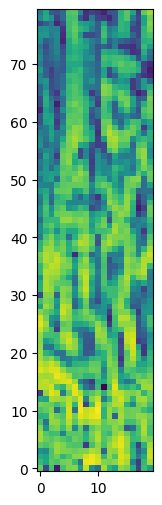

In [43]:
audio.view_mel(best_snippet.detach().to("cpu").squeeze())

# Evaluation

In [52]:
# EVALUATION
# for now, metric is whether the transcription is empty or consists only of blank tokens

def evaluate(snippet, prepare_method, model, test_dataset):
    print(f"Clamp: {CLAMP_EP}\nPrepare Method: {prepare_method.name}\nSnippet Size: {SNIPPET_SIZE}")
    empty_counter = 0
    char_counter = 0
    total_examples = 0
    original_chars = 0

    snippet = snippet.to(device)
    pbar = tqdm(range(len(test_dataset)), desc="Inference")
    test_dataset_iter = iter(test_dataset)
    model.eval()

    for i in pbar:
        # evaluate if there are any words at all
        example, answer = next(test_dataset_iter).values()
        if isinstance(answer, tuple) or isinstance(answer, list):
            answer = answer[0]
        if answer != "ignore_time_segment_in_scoring":
            attacked_example = prepare_method(snippet, example.to(device))
            transcription = model.transcribe(attacked_example.squeeze(), language="en", condition_on_previous_text=False, fp16=True)["text"]

            if not transcription.strip():
                empty_counter += 1
            char_counter += len(transcription.strip())
            original_chars += len(answer)
            total_examples += 1
            pbar.set_postfix_str(f"Valid Examples: {total_examples} | Empty Sequences: {empty_counter} | Total SL = {char_counter}")

        example.to("cpu")

    pbar.close()
    print("\n")
    print(f"Total valid examples: {total_examples}")
    print(f"Success rate (Empty): {empty_counter/total_examples}")
    print(f"Success rate (ASL): {char_counter/total_examples} (attacked) out of {original_chars/total_examples} (original)")

evaluate(best_snippet, PREPARE_METHOD, model, test_dataset) # commented to prevent the runtime from autorunning and crashing the thing

Clamp: 0.005
Prepare Method: prepare_front
Snippet Size: (1, 7200)


Inference: 100%|██████████| 250/250 [00:33<00:00,  7.55it/s, Valid Examples: 194 | Empty Sequences: 194 | Total SL = 0]



Total valid examples: 194
Success rate (Empty): 1.0
Success rate (ASL): 0.0 (attacked) out of 122.16494845360825 (original)


In [ ]:
snippets = torch.stack(list(map(lambda x: x.cpu(), snippets)) + [best_snippet.cpu()])
snippets.shape

In [ ]:
torch.save(snippets.squeeze(), "snippets.pt")

In [ ]:
torch.save(torch.stack(list(map(torch.tensor, train_success.values()))), "train_success.pt")
torch.save(torch.tensor(list(train_success.keys())), "train_ids.pt")

In [ ]:
torch.save(torch.stack(list(map(torch.tensor, valid_success.values()))), "valid_success.pt")
torch.save(torch.tensor(list(valid_success.keys())), "valid_ids.pt")

# Save and Hear Snippet

In [ ]:
def normalise(random_snippet, ep):
    # we assume torch.rand inits to [0, 1)
    res = random_snippet * ep * 2 - ep
    print(f"Normalised, Min {torch.min(res)}, Max {torch.max(res)}")
    return res

In [ ]:
# Save snippet to wav file
save_audio(snippet, f"./snippets/clamp_{CLAMP_EP}_{PREPARE_METHOD.name}_snippet_only.wav")

In [ ]:
save_audio(PREPARE_METHOD(snippet.to("cpu"), tedlium_test[2]["audio"].unsqueeze(0)), f"./snippets/clamp_{CLAMP_EP}_{PREPARE_METHOD.name}_combined.wav")